<a href="https://colab.research.google.com/github/khagerthey/VIS1/blob/main/Glass_vs_Plastic_Merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Mission

I am currently employed by a food manufacturing business. At this facility we produce sauces, dressing, and salsas for well-known brands. An escalating problem we’re experiencing is glass breakages. Glass breakages are costly, dangerous, and time consuming. It’s apparent to quickly find the cause and a solution to this on-going issue.

My manager and I share the hypothesis that the root cause of the breakages is thermal shock. For this assignment I will be investigating a possible solution of substituting our glass jars for plastic.

Plastic is a cheaper alternative, more durable, and requires less maintenance. Plastic would eliminate the glass-breakage problem entirely, or at least reduce it significantly if it were only partially transitioned to replace the most breakable glass. 


The following are my sources:

EPA data tables of MWS from 1960 to 2017:
https://www.epa.gov/facts-and-figures-about-materials-waste-and-recycling/advancing-sustainable-materials-management

Price percentage increase throughout the years via NasDaq:
Glass- https://data.nasdaq.com/data/FRED/PCU32723272-producer-price-index-by-industry-glass-and-glass-product-manufacturing
Plastic- https://data.nasdaq.com/data/FRED/ID3923-export-harmonized-system-plastic-articles-for-conveyence-of-packing-goods-discontinued

Budget reports of previous production years and a projection of the 2023 calendar year provided by my current employer. All personal information and business names have been removed. For privacy reasons, I am not approved to link budget reports used in this project.

In [1]:

import time, os, sys, re
import zipfile, json, datetime, string 
import numpy as np
from statistics import *

import matplotlib.pyplot as plt 
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler

import urllib                                                 

from google.colab import files

import webbrowser                                                                      
import folium as f                                                                     
from folium.plugins import MarkerCluster, HeatMap                                      

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter() 

#aok good; for future please update like i did with magic command %matplotlib inline  and plt.style.use('default')


# Material Price Indexes

My first data set is a table of glass price index percentages shown throughout the years. This is a data set I found on Nasdaq.com by searching for glass production packaging. I adjusted the column header "Value" to "Glass Price Index %" and averaged a yearly price index rather than monthly for sake of merging on date and clearity.

In [2]:
glass=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Glass%20price%20%25%20-%20Cleaned%20(2).csv')
glass


,Date,Glass Price Index %
0,2021,0.099254
1,2020,0.025830
2,2019,0.015060
3,2018,0.031728
4,2017,0.022138
5,2016,0.020996
6,2015,0.045122
7,2014,0.017227
8,2013,0.013121
9,2012,0.015958


The following dataset is also from Nasdaq.com, I found it while searching for plastic production packaging data. Again, I adjusted the column header "Value" to "Plastic Price Index %" and reduced the data from monthly to a yearly average for the sake of merging and clearity.

In [3]:
plastic=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Plastic%20price%20%25%20-%20Plastic%20price%20%25%20(4).csv')
plastic

,Date,Plastic Price Index %
0,2021,-0.007517
1,2020,0.012443
2,2019,0.001941
3,2018,0.000477
4,2017,0.002763
5,2016,-0.001588
6,2015,-0.001748
7,2014,0.000812
8,2013,0.000216
9,2012,0.000536


## Merging Indexes
I am merging together the price indexes between glass and plastics over the years. This is to give a clear price comparison in material.

In [4]:
mergedPercent = pd.merge(glass, plastic, how='outer', on=['Date'],indicator=True)
mergedPercent 

,Date,Glass Price Index %,Plastic Price Index %,_merge
0,2021,0.099254,-0.007517,both
1,2020,0.025830,0.012443,both
2,2019,0.015060,0.001941,both
3,2018,0.031728,0.000477,both
4,2017,0.022138,0.002763,both
5,2016,0.020996,-0.001588,both
6,2015,0.045122,-0.001748,both
7,2014,0.017227,0.000812,both
8,2013,0.013121,0.000216,both
9,2012,0.015958,0.000536,both


In [5]:
mergedPercent._merge.value_counts(sort=False)

left_only      0
right_only    10
both          18
Name: _merge, dtype: int64

Here I removed the data that did not match. The price index changes for glass 2003-1997 was not avaliable.

In [6]:
mergedPercent = pd.merge(glass, plastic, how='inner', on=['Date'],indicator=True)
mergedPercent 

,Date,Glass Price Index %,Plastic Price Index %,_merge
0,2021,0.099254,-0.007517,both
1,2020,0.025830,0.012443,both
2,2019,0.015060,0.001941,both
3,2018,0.031728,0.000477,both
4,2017,0.022138,0.002763,both
5,2016,0.020996,-0.001588,both
6,2015,0.045122,-0.001748,both
7,2014,0.017227,0.000812,both
8,2013,0.013121,0.000216,both
9,2012,0.015958,0.000536,both


Text(0.5, 1.0, 'Price Indexes')

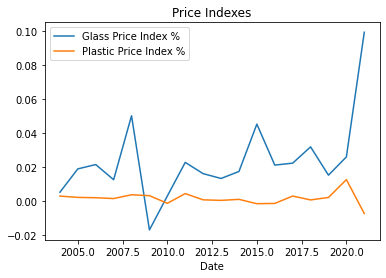

In [7]:
mergedPercent.plot(kind='line',x='Date')
plt.title('Price Indexes')

As we can see displayed from both the table and line graph, glass prices have continously raised with the exception of 2009. The percentages show either an increase or decrease in price in comparision to the previous year. Plastic proves to trend cheaper than glass. Glass is a more costly material and it is also more expensive to ship, as it is heavier than plastic.

#Material Weights

Now we will be looking at the total amount of weight of glass and plastic products generated in MSW (Municipal Solid Waste) from 1960 to 2018. This data was sourced from the United States Environmental Protection Agency. This data was found by searching for material weight progression yearly.

Weight is measured in thousands tons. Headers have been changed from "Material" and "Thousand of Tons" to "Date", "Glass Weight", and "Plastic Weight". The dataset has also been reduced to only compare glass and plastic as they are the only materials of interest for this project and for the sake of merging.


In [8]:
weight=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Copy%20of%20Food%20Packaging%20-%20Roles%2C%20Materials%2C%20and%20Environmental%20Issues%20CLEANED%20-%20Weight%20Cleaned%20(1).csv')
weight

,Date,Glass Weight,Plastic Weight
0,1960,6720,390
1,1970,12740,2900
2,1980,15130,6830
3,1990,13100,17130
4,2000,12770,25550
5,2005,12540,29380
6,2008,12150,30260
7,2010,11520,31400
8,2011,11470,31840
9,2012,11590,31920


Text(0.5, 1.0, 'Material Weights')

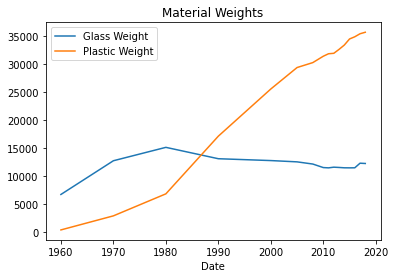

In [9]:
weight.plot(kind='line',x='Date')
plt.title('Material Weights')

Overtime the use of plastic has become more popular, especially transitioning from the 90s to the 2000s. The amount of glass has stayed consistant during this time, but the trend of plastic projects a steady increase.

##Merging Indexes and Weights

The popularity of plastics in addition of its cheaper price makes it a good resource for business.

In [10]:
mergedWeight = pd.merge(weight, mergedPercent, how='outer', on=['Date'],indicator='exists')
mergedWeight 

,Date,Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists
0,1960,6720.0,390.0,NaN,NaN,NaN,left_only
1,1970,12740.0,2900.0,NaN,NaN,NaN,left_only
2,1980,15130.0,6830.0,NaN,NaN,NaN,left_only
3,1990,13100.0,17130.0,NaN,NaN,NaN,left_only
4,2000,12770.0,25550.0,NaN,NaN,NaN,left_only
5,2005,12540.0,29380.0,0.018766,0.001972,both,both
6,2008,12150.0,30260.0,0.050063,0.003518,both,both
7,2010,11520.0,31400.0,0.002797,-0.001514,both,both
8,2011,11470.0,31840.0,0.022586,0.004201,both,both
9,2012,11590.0,31920.0,0.015958,0.000536,both,both


In [ ]:
mergedWeight.exists.value_counts(sort=False)

left_only      5
right_only     7
both          11
Name: exists, dtype: int64

Below is the data after removing what did not match. The merged price indexes do not go further than 2000. The material weights only provided data up to 2018.

In [ ]:
mergedWeight = pd.merge(weight, mergedPercent, how='inner', on=['Date'],indicator='exists')
mergedWeight

,Date,Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists
0,2005,12540,29380,0.018766,0.001972,both,both
1,2008,12150,30260,0.050063,0.003518,both,both
2,2010,11520,31400,0.002797,-0.001514,both,both
3,2011,11470,31840,0.022586,0.004201,both,both
4,2012,11590,31920,0.015958,0.000536,both,both
5,2013,11540,32620,0.013121,0.000216,both,both
6,2014,11480,33390,0.017227,0.000812,both,both
7,2015,11470,34480,0.045122,-0.001748,both,both
8,2016,11480,34870,0.020996,-0.001588,both,both
9,2017,12300,35410,0.022138,0.002763,both,both


Weight compared to cost shows that the cheaper material is generated more. Both years had a much larger weight of plastic and a cheaper price alternative to glass.

#Company Material Usage

The following are the averages of the amount of glass and plastic jars accounted for in the final product throughout the past 20 years. Note: the actual count of materials is higher than what is projected below due to breakages, product holds, and other complications which may have occurred during production.

aok: would be useful to have all data incl projected and actual

Each case contains 12 jars of product.

In [11]:
count=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Glass%20Count%20Cleaned%20-%20Sheet1.csv')
count

,Date,Glass Cases (12-pack),Plastic Cases (12-pack)
0,2023,5326000,3392000
1,2022,5458000,5087719
2,2021,5308000,4283000
3,2020,4872000,2033000
4,2019,5794000,4870000
5,2018,5638000,4001000
6,2017,6392000,6017000
7,2016,5982000,3796000
8,2015,5048000,4007000
9,2014,5395000,4990000


Text(0.5, 1.0, 'Company Material Usage')

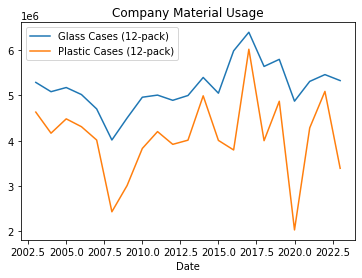

In [12]:
count.plot(kind='line',x='Date')
plt.title('Company Material Usage')

As seen above, this company tends to produce more glass cases rather than plastics. With the expection of one year in which a plant devoted to a specific brand's dressing which is packaged in plastic ( and then unfortunately closed down later that year).

##Merging Indexes, Weights, and Company Usage

Below I have merged today all three data sources. This chart shows the amount of jars (glass and plastic) my company consumes yearly, comparision weight of the material being generated across the country, and the cost of these materials.

This dataset has been reduced to only show the total glass and plastic finished goods case counts. Headers have been adjusted for the sake of merging.

aok: can adjust headers in python with rename function (and can also drop rows you dont need with drop function)
https://www.google.com/search?client=firefox-b-1-d&q=pandas+rename+

https://www.google.com/search?client=firefox-b-1-d&q=pandas+drop

In [13]:
mergedCount = pd.merge(count, mergedWeight, how='outer', on=['Date'], indicator='accounted')
mergedCount

,Date,Glass Cases (12-pack),Plastic Cases (12-pack),Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists,accounted
0,2023,5326000.0,3392000.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2022,5458000.0,5087719.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,2021,5308000.0,4283000.0,NaN,NaN,0.099254,-0.007517,both,right_only,both
3,2020,4872000.0,2033000.0,NaN,NaN,0.025830,0.012443,both,right_only,both
4,2019,5794000.0,4870000.0,NaN,NaN,0.015060,0.001941,both,right_only,both
5,2018,5638000.0,4001000.0,12250.0,35680.0,0.031728,0.000477,both,both,both
6,2017,6392000.0,6017000.0,12300.0,35410.0,0.022138,0.002763,both,both,both
7,2016,5982000.0,3796000.0,11480.0,34870.0,0.020996,-0.001588,both,both,both
8,2015,5048000.0,4007000.0,11470.0,34480.0,0.045122,-0.001748,both,both,both
9,2014,5395000.0,4990000.0,11480.0,33390.0,0.017227,0.000812,both,both,both


In [ ]:
mergedCount.accounted.value_counts(sort=False)

left_only     10
right_only     0
both          11
Name: accounted, dtype: int64

Below shows the same variables with the missing data removed for a cleaner comparision. The data that did not merge was missing from the previous merges and was expected.

In [ ]:
mergedCount = pd.merge(count, mergedWeight, how='inner', on=['Date'], indicator='accounted')
mergedCount

,Date,Glass Cases (12-pack),Plastic Cases (12-pack),Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists,accounted
0,2018,5638000,4001000,12250,35680,0.031728,0.000477,both,both,both
1,2017,6392000,6017000,12300,35410,0.022138,0.002763,both,both,both
2,2016,5982000,3796000,11480,34870,0.020996,-0.001588,both,both,both
3,2015,5048000,4007000,11470,34480,0.045122,-0.001748,both,both,both
4,2014,5395000,4990000,11480,33390,0.017227,0.000812,both,both,both
5,2013,4997000,4012000,11540,32620,0.013121,0.000216,both,both,both
6,2012,4891000,3920000,11590,31920,0.015958,0.000536,both,both,both
7,2011,5006000,4201000,11470,31840,0.022586,0.004201,both,both,both
8,2010,4959000,3829000,11520,31400,0.002797,-0.001514,both,both,both
9,2008,4016000,2433000,12150,30260,0.050063,0.003518,both,both,both


In [ ]:
mergedCount[:20].style.background_gradient(cmap='Greens')

,Date,Glass Cases (12-pack),Plastic Cases (12-pack),Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists,accounted
0,2018,5638000,4001000,12250,35680,0.031728,0.000477,both,both,both
1,2017,6392000,6017000,12300,35410,0.022138,0.002763,both,both,both
2,2016,5982000,3796000,11480,34870,0.020996,-0.001588,both,both,both
3,2015,5048000,4007000,11470,34480,0.045122,-0.001748,both,both,both
4,2014,5395000,4990000,11480,33390,0.017227,0.000812,both,both,both
5,2013,4997000,4012000,11540,32620,0.013121,0.000216,both,both,both
6,2012,4891000,3920000,11590,31920,0.015958,0.000536,both,both,both
7,2011,5006000,4201000,11470,31840,0.022586,0.004201,both,both,both
8,2010,4959000,3829000,11520,31400,0.002797,-0.001514,both,both,both
9,2008,4016000,2433000,12150,30260,0.050063,0.003518,both,both,both


In conclusion, plastic is a viable alternative for this company. Plastic is likely to remain cheaper than glass and is more durable, thus reducing breakages. Plastic packaging has become more popular and normalized throughout the years, meaning the company will less likely stand out by converting. 



#Glass Alternatives

In the case that my company would like to continue using glass, Borosilicate is a great glass alternative to Soda-lime.
Below is a table sourced from Kopp Glass. https://www.koppglass.com/blog/3-common-glass-types-properties-and-applications

In [ ]:
glasstypes=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Glass%20Types%20-%20Sheet1.csv')
glasstypes

,Glass Type,Primary Components,Linear Thermal Expansion,Thermal Shock Resistance,Chemical Resistance,Applications
0,Borosilicate,"SiO2, B2O3",-30-60 x 10-7/°C,Average - High,High,Industrial equipment\nExterior lighting\nLabor...
1,Soda-lime silicate,"SiO2, Na2O, CaO",-80-100 x 10-7/°C,Low,Average,Flood and beverage containers\nWindows\nLamp e...
2,Phosphates,P2O5,-90-110 x 10-7/°C,Low,"Low, except high resistance to hydrofluoric acid",Bone scaffolds\nOptical fibers\nHeat absorbers


Thermal shock is suspected to be the root cause for the current glass breakages. Borosilicate have a higher thermal shock resistance, making it a better choice for hot pack production.

Below is a table comparision of the material compounds of each glass type. Table sourced from CamLab. https://camblab.info/borosilicate-glass-vs-soda-lime-glass-vs-pyrex-what-is-the-difference/

In [14]:
glasscompounds=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Glass%20compounds%20-%20Sheet4%20(1).csv')
glasscompounds = glasscompounds.rename(columns={'Compound':'Glass Type'})
glasscompounds['Glass Type'].replace({'Borosilicate Glass – % content':'Borosilicate'})
glasscompounds
#'Compound' header has been changed to 'Glass Type' to merge

,Glass Type,Silicon Dioxide SiO2,Boron Trioxide B2O3,Sodium Oxide Na2O,Aluminium Oxide Al2O3
0,Borosilicate Glass – % content,80.6,13,4,2.4
1,Soda Lime Glass – % content,69.0,1,13,4.0


In [15]:
glasscompounds['Glass Type'] = glasscompounds['Glass Type'].replace(['Borosilicate Glass – % content'], 'Borosilicate')
glasscompounds['Glass Type'] = glasscompounds['Glass Type'].replace(['Soda Lime Glass – % content'], 'Soda-lime silicate')
#Material names changed to merge with first table
glasscompounds

,Glass Type,Silicon Dioxide SiO2,Boron Trioxide B2O3,Sodium Oxide Na2O,Aluminium Oxide Al2O3
0,Borosilicate,80.6,13,4,2.4
1,Soda-lime silicate,69.0,1,13,4.0


In [16]:
glasscompounds[:10].style.background_gradient(cmap='Greens')

,Glass Type,Silicon Dioxide SiO2,Boron Trioxide B2O3,Sodium Oxide Na2O,Aluminium Oxide Al2O3
0,Borosilicate,80.600000,13,4,2.400000
1,Soda-lime silicate,69.000000,1,13,4.000000


While both materials are made from the same compounds, the difference is in the proportion. Borosilicate has a tighter bind making it more durable, have a higher melting point, and be more chemically resistent. Color is used above to show the contrast in proportion.

In [42]:
#avoid hand hacking; use code
names = list(glasscompounds.columns)[1:]
names
values=glasscompounds[glasscompounds['Glass Type']=='Borosilicate'].values.flatten().tolist()[1:]
values

[80.6, 13, 4, 2.4]

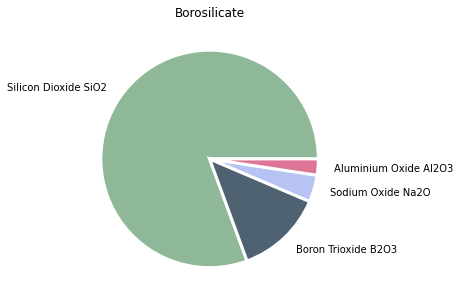

In [43]:
plt.rcParams["figure.figsize"] = (20,5)
#names='Silicon Dioxide SiO2','Boron Trioxide B2O3','Sodium Oxide Na2O','Aluminium Oxide AI2O3',
#values=[80.6,13,4,2.4]
colors = ['#8EB897','#4F6272', '#B7C3F3', '#DD7596']
plt.pie(values, labels=names, labeldistance=1.15, wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'}, colors=colors);
plt.title('Borosilicate')
plt.show();

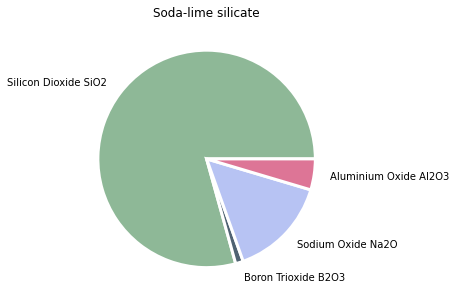

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
names='Silicon Dioxide SiO2','Boron Trioxide B2O3','Sodium Oxide Na2O','Aluminium Oxide AI2O3',
values=[69,1,13,4]
colors = ['#8EB897','#4F6272', '#B7C3F3', '#DD7596']
plt.pie(values, labels=names, labeldistance=1.15, wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'}, colors=colors);
plt.title('Soda-lime silicate')
plt.show();

These pie charts show the clear difference in chemical composition between the two materials. Boron Trioxide B2O3 stands out the most as Borosilicate contains more, which contributes to it's high thermal shock resistance.

In [ ]:
mergedglass = pd.merge(glasstypes, glasscompounds, how='outer', on=['Glass Type'], indicator='present')
mergedglass

,Glass Type,Primary Components,Linear Thermal Expansion,Thermal Shock Resistance,Chemical Resistance,Applications,Silicon Dioxide SiO2,Boron Trioxide B2O3,Sodium Oxide Na2O,Aluminium Oxide Al2O3,present
0,Borosilicate,"SiO2, B2O3",-30-60 x 10-7/°C,Average - High,High,Industrial equipment\nExterior lighting\nLabor...,80.6,13.0,4.0,2.4,both
1,Soda-lime silicate,"SiO2, Na2O, CaO",-80-100 x 10-7/°C,Low,Average,Flood and beverage containers\nWindows\nLamp e...,69.0,1.0,13.0,4.0,both
2,Phosphates,P2O5,-90-110 x 10-7/°C,Low,"Low, except high resistance to hydrofluoric acid",Bone scaffolds\nOptical fibers\nHeat absorbers,NaN,NaN,NaN,NaN,left_only


In [ ]:
mergedglass.present.value_counts(sort=False)
#expected not to merge on Phosphates, as there was no data given on the second table

left_only     1
right_only    0
both          2
Name: present, dtype: int64

In [ ]:
mergedglass = pd.merge(glasstypes, glasscompounds, how='inner', on=['Glass Type'], indicator='present')
mergedglass

,Glass Type,Primary Components,Linear Thermal Expansion,Thermal Shock Resistance,Chemical Resistance,Applications,Silicon Dioxide SiO2,Boron Trioxide B2O3,Sodium Oxide Na2O,Aluminium Oxide Al2O3,present
0,Borosilicate,"SiO2, B2O3",-30-60 x 10-7/°C,Average - High,High,Industrial equipment\nExterior lighting\nLabor...,80.6,13,4,2.4,both
1,Soda-lime silicate,"SiO2, Na2O, CaO",-80-100 x 10-7/°C,Low,Average,Flood and beverage containers\nWindows\nLamp e...,69.0,1,13,4.0,both


Borosilicate is a great alternative to Soda-lime. With it's high chemical resistence, it makes products taste better because it does not leach out. Borosilicate is more expensive than Soda-lime, but may be a cheaper solution than expanding the company's current glass heating storage.

aok: ok we got some results but need to develop a story for ps4